# TensorFlow1 推理

下面以模型 [resnet_v2_50](http://download.tensorflow.org/models/resnet_v2_50_2017_04_14.tar.gz) 为例展示。

需要克隆项目 [models](https://github.com/tensorflow/models)，然后执行如下操作。

In [1]:
import tensorflow as tf
try:
    tf1 = tf.compat.v1
    # tf1.disable_v2_behavior()
except (ImportError, AttributeError):
    tf1 = tf

2023-06-21 16:45:50.343922: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 16:45:50.436661: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-21 16:45:50.437837: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-21 16:45:52.022624: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


切换到 `models/research/slim` 目录下：

In [2]:
%cd /media/pc/data/lxw/ai/tasks/models/research/slim

/media/pc/data/lxw/ai/tasks/models/research/slim


定义缓存目录：

In [3]:
checkpoints_dir = '/tmp/checkpoints'

下载权重文件：

In [4]:
from datasets import dataset_utils

url = "http://download.tensorflow.org/models/resnet_v2_50_2017_04_14.tar.gz"

if not tf1.gfile.Exists(checkpoints_dir):
    tf1.gfile.MakeDirs(checkpoints_dir)

dataset_utils.download_and_uncompress_tarball(url, checkpoints_dir)

>> Downloading resnet_v2_50_2017_04_14.tar.gz 100.0%
Successfully downloaded resnet_v2_50_2017_04_14.tar.gz 286441851 bytes.


图像预处理：

In [5]:
import tensorflow as tf


def preprocessing(
    image,
    use_grayscale=False,
    central_fraction=0.875,
    central_crop=True,
    height=299,
    width=299,
    mean: tuple[float, ...] = (0.485, 0.456, 0.406),
    std: tuple[float, ...] = (1, 1, 1)
):
    # image = tf.constant(image)
    if image.dtype != tf.float32:
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    if use_grayscale:
        image = tf.image.rgb_to_grayscale(image)
    if central_crop and central_fraction:
        image = tf.image.central_crop(image, central_fraction=central_fraction)
    if height and width:
        image = tf.expand_dims(image, 0)
        image = tf.image.resize(image, [height, width],
                                method='bilinear',
                                preserve_aspect_ratio=False,
                                antialias=False)
        image = tf.squeeze(image, [0])
    image = tf.subtract(image, mean)
    image = tf.divide(image, std)
    return image

定义模型并推理：

In [6]:
from PIL import Image
import numpy as np
from nets import resnet_v2
import tf_slim as slim
from tvm_book.data.classification import ImageFolderDataset

root = "/media/pc/data/lxw/home/data/datasets/ILSVRC/val"
valset = ImageFolderDataset(root)

# preprocessing = get_preprocessing("resnet_v2_50")
image_size = 224
image, label_id = valset[1001]
# MEAN = np.array([123.68, 116.78, 103.94]) / 256
with tf1.Graph().as_default():
    processed_image = preprocessing(
        image,
        use_grayscale=False,
        central_fraction=0.875,
        central_crop=True,
        height=299,
        width=299,
        mean=(0.485, 0.456, 0.406),
        std=(1, 1, 1)
    )
    processed_images  = tf.expand_dims(processed_image, 0)
    
    # 创建模型时，使用默认的参数范围（arg scope）来配置批归一化（batch norm）参数。
    with slim.arg_scope(resnet_v2.resnet_arg_scope()):
        logits, _ = resnet_v2.resnet_v2_50(processed_images, num_classes=1001,
                                           global_pool=True,
                                           is_training=False)
    probabilities = tf.nn.softmax(logits)
    
    init_fn = slim.assign_from_checkpoint_fn(
        f'{checkpoints_dir}/resnet_v2_50.ckpt',
        slim.get_model_variables('resnet_v2_50'))
    
    with tf1.Session() as sess:
        init_fn(sess)
        np_processed_image, np_probabilities = sess.run([processed_image, probabilities])

/media/pc/data/tmp/cache/conda/envs/tvmz/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


INFO:tensorflow:Restoring parameters from /tmp/checkpoints/resnet_v2_50.ckpt


2023-06-21 16:47:02.449926: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-06-21 16:47:02.514985: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled


打印标签信息：

In [7]:
from tvm_book.data.imagenet.classification import ImageNet1kAttr

imagenet1k_attr = ImageNet1kAttr()
sorted_inds = np_probabilities[0].argsort()[::-1]
topk = 5
print(f"真实标签：{imagenet1k_attr.classes_long[label_id]}")
for sorted_ind in sorted_inds[:topk]:
    label = imagenet1k_attr.classes_long[sorted_ind-1]
    print(f"{sorted_ind-1}: {label.ljust(38)}\t{np_probabilities[0, sorted_ind]}")

真实标签：water ouzel, dipper
20: water ouzel, dipper                   	0.9207783937454224
143: oystercatcher, oyster catcher         	0.014078204520046711
141: redshank, Tringa totanus              	0.0032907347194850445
146: albatross, mollymawk                  	0.0032017454504966736
139: ruddy turnstone, Arenaria interpres   	0.002742304001003504


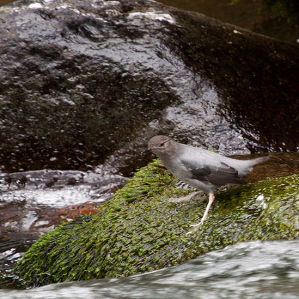

In [8]:
Image.fromarray(((np_processed_image+(0.485, 0.456, 0.406))*256).astype(np.uint8))